In [1]:

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import clone

# Обучение модели

## Загружаем данные из pickle

In [2]:
model_file = open('processed_data2.pkl', 'rb')
data = pickle.load(model_file)
model_file.close()
data

,duration,rounds,f1_age,f2_age,f1_isHomeCity,f1_isHomeCountry,f1_isHomeTimezone,f2_isHomeCity,f2_isHomeCountry,f2_isHomeTimezone,...,grappling_accuracy_difference,hitsTotal_difference,takedownTotal_difference,submissionAttempts_difference,takeovers_difference,hitsBodyTotal_difference,hitsLegsTotal_difference,weight_difference,height_difference,eventDate
id,,,,,,,,,,,,,,,,,,,,,
5201,104.0,1.0,27.0,34.0,0,0,0,0,0,0,...,0.0,4.0,3.0,1.0,0.0,0.0,1.0,-18.6,-10.2,1993-11-12 00:00:00
5202,52.0,1.0,24.0,23.0,0,1,0,0,1,0,...,0.0,2.0,2.0,1.0,0.0,0.0,0.0,2.3,-7.6,1993-11-12 00:00:00
5203,59.0,1.0,23.0,34.0,0,1,0,0,0,0,...,0.0,-14.0,0.0,0.0,0.0,0.0,-2.0,26.8,-2.5,1993-11-12 00:00:00
5204,57.0,1.0,29.0,27.0,0,1,0,0,0,0,...,0.0,-12.0,0.0,-1.0,-1.0,0.0,0.0,13.6,0.0,1993-11-12 00:00:00
5205,138.0,1.0,27.0,30.0,0,0,0,0,1,0,...,0.0,7.0,1.0,0.0,0.0,0.0,2.0,-9.5,0.0,1993-11-12 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5310,260.0,1.0,25.0,25.0,0,1,0,0,1,1,...,-1.0,19.0,1.0,1.0,0.0,0.0,0.0,0.0,7.6,2019-12-08 05:00:00
6338,300.0,3.0,30.0,22.0,0,1,0,0,0,0,...,0.0,71.0,1.0,0.0,0.0,1.0,-2.0,0.0,-5.1,2019-12-08 05:00:00
5311,300.0,5.0,31.0,35.0,0,0,0,0,0,0,...,0.0,6.0,2.0,-1.0,0.0,2.0,1.0,0.0,-2.5,2019-12-14 00:00:00


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6285 entries, 5201 to 6340
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   duration                        6285 non-null   float64       
 1   rounds                          6285 non-null   float64       
 2   f1_age                          6285 non-null   float64       
 3   f2_age                          6285 non-null   float64       
 4   f1_isHomeCity                   6285 non-null   int64         
 5   f1_isHomeCountry                6285 non-null   int64         
 6   f1_isHomeTimezone               6285 non-null   int64         
 7   f2_isHomeCity                   6285 non-null   int64         
 8   f2_isHomeCountry                6285 non-null   int64         
 9   f2_isHomeTimezone               6285 non-null   int64         
 10  winner                          6285 non-null   bool          
 11  K

## Выбираем независимые и целевую переменные

### Выбираем период для обучающей и тестовой выборки 

In [3]:
X = data.drop(columns=['winner'])
y = data[['winner', 'eventDate']]
X_train = X[X['eventDate'].dt.year < 2019].drop(columns=['eventDate'])
X_test = X[X['eventDate'].dt.year >= 2019].drop(columns=['eventDate'])
y_with_date_to_train = y[y['eventDate'].dt.year < 2019]
y_with_date_to_test = y[y['eventDate'].dt.year >= 2019]

In [4]:
Y_train = y_with_date_to_train['winner']
Y_test = y_with_date_to_test['winner']

### Стандартизуем данные для обучения моделей

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Импортируем различные модели

In [6]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from tensorflow.keras import models
from tensorflow.keras import layers

### Пишем функции, определяющие параметры и конфигурацию моделей, метрика - accuracy

In [42]:


def percep(X_train,Y_train,X_test,Y_test,Models):
    perceptron = Perceptron(max_iter = 1000, tol = 0.001)
    perceptron.fit(X_train, Y_train)
    Y_pred = perceptron.predict(X_test)
    Models['Perceptron'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def ranfor(X_train,Y_train,X_test,Y_test,Models):
    randomfor = RandomForestClassifier(max_features="sqrt",
                                       n_estimators = 700,
                                       max_depth = None,
                                       n_jobs=-1
                                      )
    randomfor.fit(X_train,Y_train)
    Y_pred = randomfor.predict(X_test)
    Models['Random Forests'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def dec_tree(X_train,Y_train,X_test,Y_test,Models):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, Y_train)
    Y_pred = decision_tree.predict(X_test)
    Models['Decision Tree'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def SGDClass(X_train,Y_train,X_test,Y_test,Models):
    sgd = SGDClassifier(max_iter = 1000, tol = 0.001)
    sgd.fit(X_train, Y_train)
    Y_pred = sgd.predict(X_test)
    Models['SGD Classifier'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def linSVC(X_train,Y_train,X_test,Y_test,Models):
    linear_svc = LinearSVC()
    linear_svc.fit(X_train, Y_train)
    Y_pred = linear_svc.predict(X_test)
    Models['SVM'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def bayes(X_train,Y_train,X_test,Y_test,Models):
    gaussian = GaussianNB()
    gaussian.fit(X_train, Y_train)
    Y_pred = gaussian.predict(X_test)
    Models['Bayes'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def Nearest(X_train,Y_train,X_test,Y_test,Models):
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    Models['KNN'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]

def XGB(X_train,Y_train,X_test,Y_test,Models):
    D_train = xgb.DMatrix(X_train, label=Y_train)
    D_test = xgb.DMatrix(X_test, label=Y_test)
    param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 
    steps = 20
    xgb_model = xgb.train(param, D_train, steps)
    preds = xgb_model.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    Models['XGB'] = [accuracy_score(Y_test, best_preds)]

def DNN(X_train,Y_train,X_test,Y_test,Models):
    model= models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(24,)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
    
    model.fit(X_train, Y_train, epochs=5, batch_size=32, verbose=0)
    
    Models['DNN'] = [model.evaluate(X_test, Y_test, verbose=0)[1]]
    

def run_all_and_Plot(X_train, X_test, Y_train, Y_test):
    Models = dict()

    percep(X_train,Y_train,X_test,Y_test,Models)
    ranfor(X_train,Y_train,X_test,Y_test,Models)
    dec_tree(X_train,Y_train,X_test,Y_test,Models)
    SGDClass(X_train,Y_train,X_test,Y_test,Models)
    linSVC(X_train,Y_train,X_test,Y_test,Models)
    bayes(X_train,Y_train,X_test,Y_test,Models)
    Nearest(X_train,Y_train,X_test,Y_test,Models)
    XGB(X_train,Y_train,X_test,Y_test,Models)
    DNN(X_train,Y_train,X_test,Y_test,Models)
    return Models


def plot_bar(dict):
    labels = tuple(dict.keys())
    y_pos = np.arange(len(labels))
    values = [dict[n][0] for n in dict]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, labels,rotation='vertical')
    plt.ylabel('accuracy')
    plt.title('Accuracy разных моделей')
    plt.show()


### Обучаем модели и строим графики

/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[09:35:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Perceptron 0.64
Random Forests 0.72
Decision Tree 0.72
SGD Classifier 0.68
SVM 0.68
Bayes 0.67
KNN 0.6
XGB 0.71
DNN 0.71


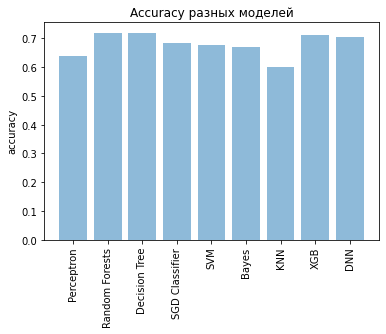

In [43]:
accuracies = run_all_and_Plot(X_train, X_test, Y_train, Y_test)
CompareAll = dict()
CompareAll['Baseline'] = accuracies
for key,val in accuracies.items():
    print(str(key) +' '+ str(round(val[0],2)))
plot_bar(accuracies)

# Вывод:
Для дальнейшего файнтюнинга наиболее перспективными показали себя алгоритмы дерева принятия решений, случайный лес, XGB и нейронная сеть.